In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
from rich.progress import track

import data_loader.data_loaders as module_data
import model.model as module_arch
from configs import configs
from utils.plot_utils import plot_relavant_features, plot_relevances_amplitudes
from utils.utils import read_json

Output()

Output()

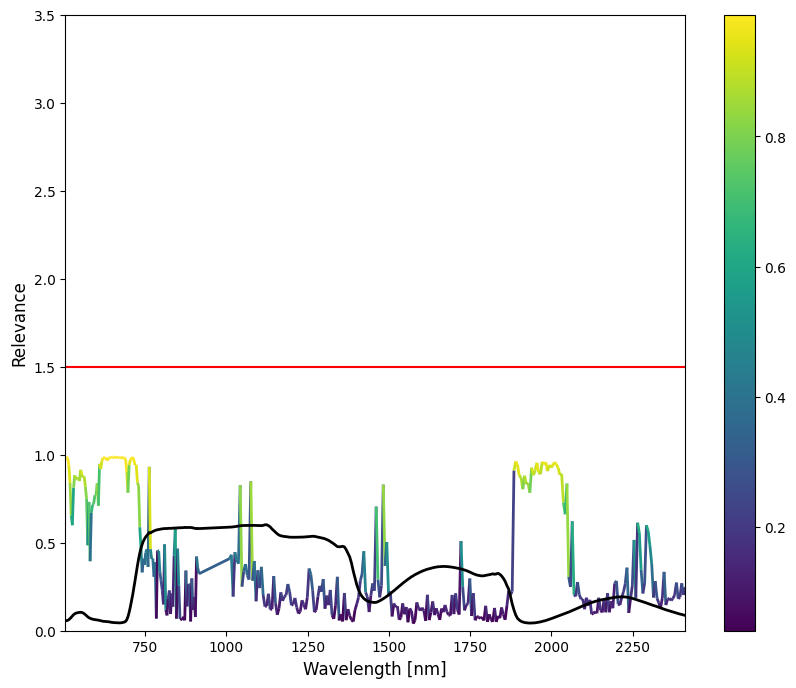

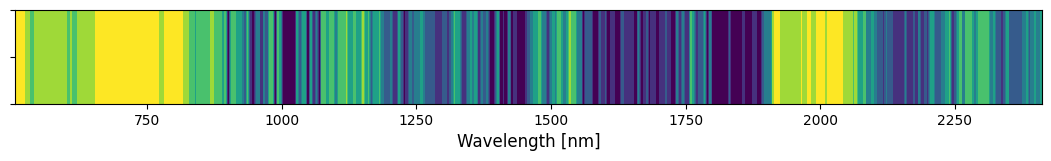

In [3]:

run_id = "fe7c023d3ad94aeabb2f6fd23a1d031f"
experiment_id = mlflow.get_run(run_id=run_id).info.experiment_id
artifacts_base_path = Path(configs.MODEL_REGISTRY, experiment_id, run_id, "artifacts")
config = read_json(artifacts_base_path / "configs/config.json")
checkpoint = torch.load(artifacts_base_path / "checkpoints/model_best.pth")

state_dict = checkpoint["state_dict"]
model = getattr(module_arch, config["arch"]["type"])(**config["arch"]["args"])
model.load_state_dict(state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

data_loader = getattr(module_data, config["data_loader"]["type"])(
	configs.DATA_DIR,
	config["data_loader"]["args"]["dataset"],
	config["data_loader"]["args"]["data_sampler"],
	train_test_split_size=config["data_loader"]["args"]["train_test_split_size"],
	train_valid_split_size=config["data_loader"]["args"]["train_valid_split_size"],
	batch_size=1,
	shuffle=False,
	training=False,
)

relevances_list = []
signatures_list = []
with torch.no_grad():
	for i, (data, target) in enumerate(track(data_loader, description="Loading data...")):
		data = data.to(device)
		signature = torch.mean(data, dim=(2, 3))
		output = model.spectral.fc1(signature)
		output = model.spectral.act1(output)
		output = model.spectral.fc2(output)
		output = model.spectral.act2(output)
		relevances_list.append(output.detach().cpu().numpy().flatten())
		signatures_list.append(signature.detach().cpu().numpy().flatten())

relevances = np.mean(relevances_list, axis=0)
signature = np.mean(signatures_list, axis=0)
indices_by_relevance = np.argsort(relevances)[::-1]
plot_relevances_amplitudes(relevances)
plt.plot(configs.BANDS, signature, color="black", linewidth=2)
plot_relavant_features(indices_by_relevance)
plt.show()